# Analysis of 10x Visium human breast cancer slice

In this tutorial, we demonstrate SpaRCL on the analysis of 10x Visium human breast cancer (block A section 1) slice including

* Spatial reconstruction
* Relational contrastive learning
* Spatial domain identification
* Spatial domain annotation
* Finding differentially expressed genes

The dataset is available at [10x genomics website](https://www.10xgenomics.com/resources/datasets) (Spatial Gene Expression >> Visium Demonstration (v1 Chemistry) >> Space Ranger 1.0.0 >> Human Breast Cancer (Block A Section 1)).

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import SpaRCL as rcl

## Data loading and preprocessing

We load the dataset and find top 2000 highly variable genes.

In [2]:
adata = sc.read_visium('./data/Human Breast Cancer (Block A Section 1)/')
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3813 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')

## Spatial reconstruction

We perform spatial reconstruction to aggregate expression from spatial neighbors.

In [4]:
rcl.spatial_reconstruction(adata)

## Relational contrastive learning

We perform relational contrastive learning on the reconstructed data.

In [5]:
rcl.run_RCL(adata)

 83%|█████████████████████████████████████████▎        | 826/1000 [04:14<00:53,  3.25it/s, err=9.73943e-06, converged!]


## Spatial domain identification

We identify spatial domians using the relation matrix.

In [6]:
sc.tl.leiden(adata, resolution=1.5, neighbors_key='relation')

... storing 'feature_types' as categorical
... storing 'genome' as categorical


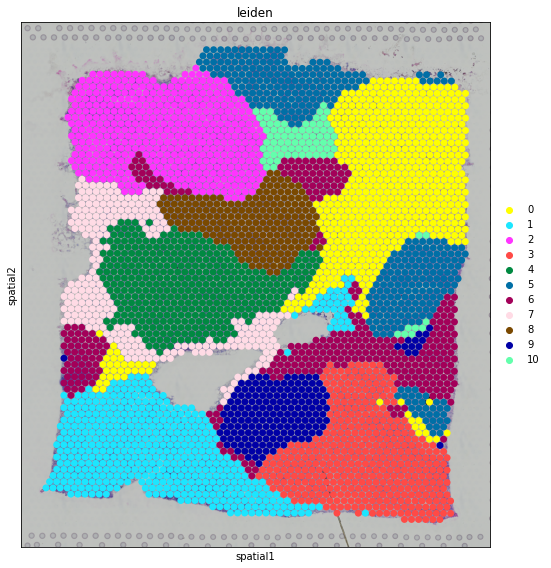

In [7]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color='leiden',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

## Spatial domain annotation

We annotate the spatial domains based on the pathologist annotation from [Fu, H. et al.](https://www.biorxiv.org/content/10.1101/2021.06.15.448542v2)

In [8]:
map_dict = {
    '0': 'Non-tumor',
    '1': 'Invasive',
    '2': 'Invasive',
    '3': 'Invasive',
    '4': 'In situ',
    '5': 'In situ',
    '6': 'Non-tumor',
    '7': 'Non-tumor',
    '8': 'Invasive',
    '9': 'In situ',
    '10': 'Non-tumor',
}

In [9]:
adata.obs['annotation'] = pd.Categorical(
    adata.obs['leiden'].map(map_dict),
    categories=['Invasive', 'In situ', 'Non-tumor']
)

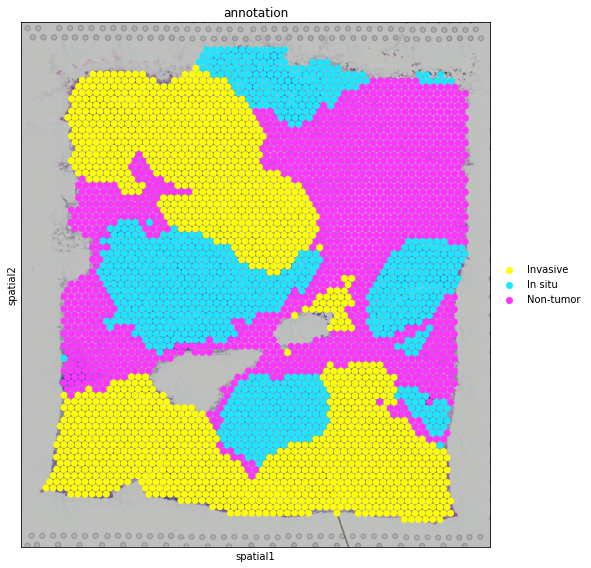

In [10]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color='annotation',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

## Finding differentially expressed genes

We find the differentially expressed (DE) genes across identified domains and show their expression patterns in spatial coordinates.

In [11]:
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False, layer='counts', method='t-test')

In [12]:
de_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[:10,:]
de_genes

,0,1,2,3,4,5,6,7,8,9,10
0,ACKR1,CXCL14,COX6C,CRISP3,CPB1,MGP,IGKC,C1QA,LINC00645,IFT122,ALB
1,CCL21,CCND1,SNCG,SLITRK6,HLA-B,S100G,IGLC2,APOE,MUC5B,S100G,MGP
2,TNXB,DEGS1,SLC39A6,S100A13,COX6C,DSP,IGHG1,C1QB,PVALB,AC087379.2,BGN
3,CLDN5,S100A11,WFDC2,IGFBP5,IL6ST,TFF1,IGHG3,FABP4,IGFBP2,IFI6,IGHG1
4,CCL19,CPNE7,CSTA,SERHL2,HLA-C,TFF3,C3,GPX3,EXOC2,CALML5,IGFBP7
5,ADAM33,DEGS2,MT-ND1,CALML5,HLA-A,MT-ND3,IGHG4,ADH1B,SLC30A8,HLA-B,COL1A1
6,C7,MUC1,MCCD1,S100A16,ADIRF,RERG,IGLC3,ADIPOQ,COLEC12,HEBP1,SFRP2
7,CHRDL1,RPLP1,RAB11FIP1,KRT8,CFB,STC2,IGHA1,FOLR2,ZNF703,TPD52,CST1
8,ADH1B,PSMB4,MT-CO1,S100A11,B2M,MT-CO1,IGHM,COL14A1,SLC39A6,HLA-A,HTRA3
9,SOD3,RPSA,UGCG,NUPR1,H2AFJ,HK2,TIMP1,HSPB6,AC037198.2,ISG15,COL1A2


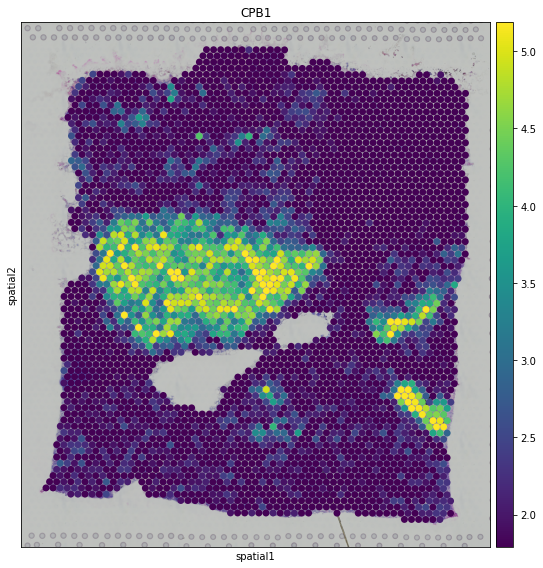

In [13]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color=de_genes.iloc[0,4],
    layer='log1p',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    vmin='p50',
    vmax='p99',
    show=False,
    ax=axs,
)

plt.tight_layout()

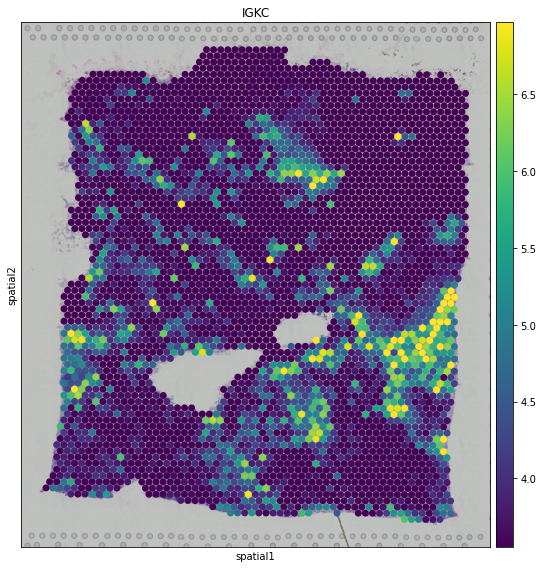

In [14]:
fig, axs = plt.subplots(figsize=(8, 8))

sc.pl.spatial(
    adata,
    img_key='hires',
    color=de_genes.iloc[0,6],
    layer='log1p',
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    vmin='p50',
    vmax='p99',
    show=False,
    ax=axs,
)

plt.tight_layout()